# Free Energy Calculations
In this Notebook, we want to give a short glimpse on Free Energy Calculations with Ensembler. 

Free energies are an very important topic in computational chemistry. As they are fundamental to thermodynamics and can give a lot of information for different changes to a system. Generally we can destinguish three types of free energies: thermodynamic, conformational and alchemical. 
The thermodynamic category is a free energy difference related to a change of an thermodynamic property of the system. The conformational free energy difference can be used to describe a conformational change of a molecule (phase space areas) and the alchemical free energy is describing a change in the chemical space of the molecule (e.g.: methylation).

To calculate a free energy can be very tricky. Challenges might be sampling convergence due to high energy barriers or entropy differences. 


To be able to estimate the influence of a chemical change, one needs to calculate the free energies of both so called states.




Here we calculate the Gibbs Free Energy.

$A_x = V_x - T_x  S_x = -\beta ln(Z_x) $



Get to stat therm:

Or we can use the statistical approach:

$G_x = -\frac{1}{\beta}  ln(e^{-\beta H_x})$

With the Gibbs Free Energy of state i and state J we can get the Free Energy Difference of the change.

$\Delta G_{ij} = G_j - G_i = -\beta ln(Z_i/Z_j)$ 

This allows us to estimate the influence of the change.

A free energy Calculation can be described contains three parts:
* The System: Normally these contian multiple states.
* The Sampling Method: The way how the Free Energy landscape will be integrated.
* The Free Energy Estimator: The way, the free energy will be derived from the simulation.


In this notebook we will cover following methods:
* Free Energy Pertubation
  * Zwanzig
  * BAR
* linear coupling
    * TI
* exponential coupling
    * EDS
* hybrid coupling
    * $\lambda$-EDS
* Enhanced Sampling methods:
    * Conveyor Belt
    * RE-EDS


References:
    - a good page to learn about free energies: http://www.alchemistry.org 

In [1]:
#Here some imports:

##System Path
import os, sys
path = os.getcwd()+"/.."
sys.path.append(path)

##basics
import numpy as np
from matplotlib import pyplot as plt

##Ensembler
from ensembler.analysis.freeEnergyCalculation import zwanzigEquation, threeStateZwanzigReweighting, bennetAcceptanceRatio

from ensembler.potentials import OneD as pot
from ensembler.integrator.stochastic import metropolisMonteCarloIntegrator, langevinIntegrator
from ensembler.system.basic_system import system
from ensembler.system.perturbed_system import perturbedSystem
from ensembler.system.eds_system import edsSystem

from ensembler.visualisation.plotSimulations import static_sim_plots

from ensembler.conditions.box_conditions import periodicBoundaryCondition


import matplotlib
from ensembler.visualisation import style
from ensembler.visualisation import plot_layout_settings
for key, value in plot_layout_settings.items():
    matplotlib.rcParams[key] = value


C:\Users\benja\anaconda3\envs\testBar\lib\site-packages\scipy\__init__.py:115: UserWarning: Numpy 1.13.3 or above is required for this version of scipy (detected version 1.11.3)
  UserWarning)


## Benchmarking parameters
Here we define some parameters that allow us an easier comparison of the different methods.

In [2]:
simulation_steps_total_per_approach = 10000
space_range = [-10, 10]
rand=0.1


## Setting up a System
We are now going to Setup a system, for the Free Energy Calculations. For this Notebook, we want to keep it simple. Therefore two 1D-Harmonic Oscillators with different shifted minima and force constants shall be perfect for us.



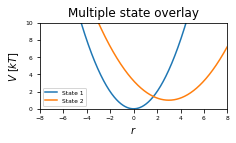

In [236]:
#Build System
#System Parameters:
yoff1 = 0
xoff1 = 0
force_constant = k1 = 1

entropic_difference = k2 =0.5
potential_difference = yoff2 = 1
phase_space_distance = xoff2 = 3

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

#Visualize
from ensembler.visualisation.plotPotentials import multiState_overlays

fig, _ = multiState_overlays([h1,h2])
fig.tight_layout()
#fig.savefig("2state_systems.png")


## Analyctical Solution
The Analytical solution for our problem can be calculated as follows: 


Check Eq

Gibbs Energy:   
$ A_x = V_x - T_x  S_x $

For a harmonic Oscillator the entropy term can be formulated as:

$A_x = V_x - \frac{1}{\beta} log(\sqrt{\frac{2 \pi}{k_X \beta}})$



The final free energy difference is:

$\Delta G_{ij} = G_j - G_i$ 


In [4]:
#Analytical Solution
beta = 1 # beta is in kT

G_1 = yoff1 -(1/(2*beta)) * np.log(np.sqrt((2*np.pi)/(k1*beta)))
G_2 = yoff2 -(1/(2*beta)) * np.log(np.sqrt((2*np.pi)/(k2*beta)))
dG_expected = G_2-G_1

print("expected dG: ", dG_expected)


expected dG:  0.699006798919


## Free Energy Pertubation Method with BAR/Zwanzig
In this Category of methods, each of the endstates will be simulated. Afterwards, the trajectories will be evaluated again with the opposite state and afterwards the free energy will be evaluated.

### Sampling
Now we build first the two systems and run the simulations.


{'bodies': [<matplotlib.collections.PolyCollection object at 0x000001946BFADA90>]}


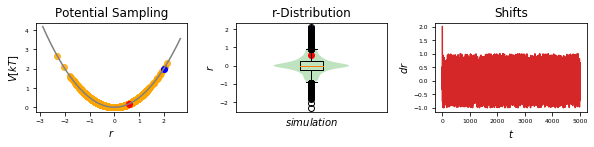

In [5]:
#Simulate the two states:
steps = simulation_steps_total_per_approach//2
equilibration_steps = 100

##Build Systems
integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
integrator2 = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)

system1 = system(potential=h1, integrator=integrator, position=2)
system2 = system(potential=h2, integrator=integrator2, position=4)

##Simulate:
system1.simulate(steps, withdrawTraj=True, initSystem=True)
state1_traj = system1.getTrajectory()
_ = static_sim_plots(system1)


{'bodies': [<matplotlib.collections.PolyCollection object at 0x000001946D52F198>]}


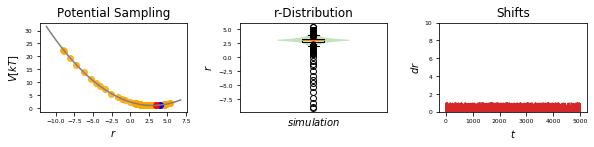

In [6]:


system2.simulate(steps, withdrawTraj=True, initSystem=True)
state2_traj = system2.getTrajectory()

#visualize
_ = static_sim_plots(system2)
plt.ylim([0,10])
pass

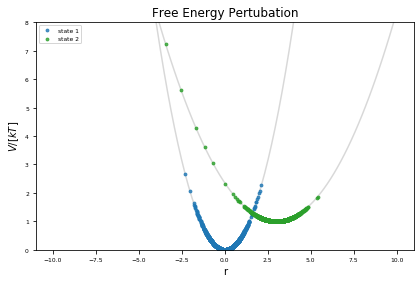

In [7]:
from ensembler import visualisation
    
positions = np.linspace(-10,10, 100)
fig, ax = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
ax = list([ax])
traj_pos = list(system1.trajectory.position)
ax[0].plot(positions, system1.potential.ene(positions), c="grey", zorder=-10,alpha=0.3)
ene = system1.potential.ene(traj_pos)
ax[0].scatter(traj_pos, ene, c="C0",alpha=0.8, label="state 1",s=8)
ax[0].set_ylim([0,8])

positions = np.linspace(-10,10, 100)
traj_pos = list(system2.trajectory.position)
ax[0].plot(positions, system2.potential.ene(positions), c="grey", zorder=-10,alpha=0.3)
ene = system2.potential.ene(traj_pos)
ax[0].scatter(traj_pos, ene, c="C2",alpha=0.8, label="state 2",s=8)
ax[0].set_ylim([0,8])

ax[0].set_xlabel("r")
ax[0].set_xlabel("r")

ax[0].set_ylabel("$V/[kT]$")
#ax[0].set_ylabel("$V/[kT]$")

ax[0].legend()
ax[0].set_title("Free Energy Pertubation")
#ax[0].set_title("State 2")

fig.savefig("freeEnergyPertubation.png")

### Analysis
#### Zwanzig Equation

In [8]:
V1=state1_traj.totEnergy[equilibration_steps:]
V2=state2_traj.totEnergy[equilibration_steps:]

zwanz = zwanzigEquation(kT=True)
dF_zwanzig = zwanz.calculate(Vi=V1, Vj=V2)

print("Expected Result: ", dG_expected)
print("Zwanzig Result: ", dF_zwanzig)
print()
print("Difference:", dF_zwanzig - dG_expected)


Expected Result:  0.699006798919
Zwanzig Result:  0.894267178878109

Difference: 0.19526037996


#### Bennet Acceptance Ratio (BAR)

In [9]:
import pymbar

In [10]:
#Sampling l1
V11=h1.ene(state1_traj.position)
V21=h2.ene(state1_traj.position)

#Sampling l2
V12=h1.ene(state2_traj.position)
V22=h2.ene(state2_traj.position)

w_fw = np.array(V21 - V11, dtype=np.float)
w_rv = np.array(V12 - V22, dtype=np.float)

(DeltaF, dDeltaF)=pymbar.BAR(w_F=w_fw, w_R=w_rv, DeltaF=0, method='bisection', verbose=False)
(DeltaF, dDeltaF)


print()
print("Expected Result: ", dG_expected)
print("pymbar - BAR Result: ", DeltaF)
print()
print("Difference:", DeltaF - dG_expected)



Expected Result:  0.699006798919
pymbar - BAR Result:  -0.312663473226

Difference: -1.01167027214


In [11]:
#Sampling l1
V11=h1.ene(state1_traj.position)
V21=h2.ene(state1_traj.position)

#Sampling l2
V12=h1.ene(state2_traj.position)
V22=h2.ene(state2_traj.position)

state_1 =np.concatenate([V11, V12])
state_2 =np.concatenate([V21, V22])
mbar = pymbar.mbar.MBAR(u_kn=[state_1, state_2], N_k=[len(state_1)/2, len(state_2)/2])
df_mbars, df, _ = mbar.getFreeEnergyDifferences()
print(df_mbars)
df_mbar = np.mean(df_mbars)

overlap, _, _ = mbar.computeOverlap()
print("overlap: ", overlap)


print()
print("Expected Result: ", dG_expected)
print("pymbar - BAR Result: ", DeltaF)
print()
print("Difference:", DeltaF - dG_expected)


[[ 0.         -0.31266347]
 [ 0.31266347  0.        ]]
overlap:  0.254197366105

Expected Result:  0.699006798919
pymbar - BAR Result:  -0.312663473226

Difference: -1.01167027214


In [12]:
#Sampling l1
V11=h1.ene(state1_traj.position)
V21=h2.ene(state1_traj.position)

#Sampling l2
V12=h1.ene(state2_traj.position)
V22=h2.ene(state2_traj.position)

bar = bennetAcceptanceRatio(kT=True)
dF_bar = bar.calculate(Vj_i=V21, Vi_i=V11, Vi_j=V12, Vj_j=V22)

print()
print("Expected Result: ", dG_expected)
print("BAR Result: ", dF_bar)
print()
print("Difference:", dF_bar - dG_expected)


Iterate: 	convergence raidus: 1e-05
Iteration: 0	dF: 2.711296593944955439511398441 	convergence 2.711296593944955439511398441
Iteration: 1	dF: 2.453103491452726147390621122 	convergence 0.258193102492229292120777319
Iteration: 2	dF: 2.472200941098567101177706119 	convergence 0.019097449645840953787084997
Iteration: 3	dF: 2.470734823169441314543694942 	convergence 0.001466117929125786634011177
Iteration: 4	dF: 2.470847082696098381779299791 	convergence 0.000112259526657067235604849
Iteration: 5	dF: 2.470838485332821804065404985 	convergence 0.000008597363276577713894806

Final Iterations:  5  Result:  2.470838485332821804065404985

Expected Result:  0.699006798919
BAR Result:  2.470838485332822

Difference: 1.77183168641


# Linear Coupling Method - Thermodynamic Integration (TI)

## Sampling

Text(0.5, 1.0, 'Sampled Potentials')

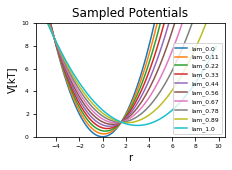

In [13]:
#Build Potential
V_perturbed = pot.linearCoupledPotentials(Va=h1, Vb=h2)

#Visualize
lambda_points = 10
positions = np.arange(-5,10, 0.2)
lambda_windows=np.linspace(0,1, lambda_points)
for lam in lambda_windows:
    V_perturbed.set_lam(lam)
    ene =  V_perturbed.ene(positions)
    plt.plot(positions,ene, label="lam_"+str(round(lam, 2)))
    
plt.legend()
plt.ylim([0,10])
plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")

In [14]:
steps = simulation_steps_total_per_approach//lambda_points
equilibration_steps = 30

integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
perturbed_system = perturbedSystem(potential=V_perturbed, integrator=integrator)

system_trajs = {}
for lam in lambda_windows:
    perturbed_system.set_lam(lam)
    perturbed_system.simulate(steps, withdrawTraj=True, initSystem=True)
    system_trajs.update({lam: perturbed_system.trajectory})


### Analysis

#### Exponential Formula

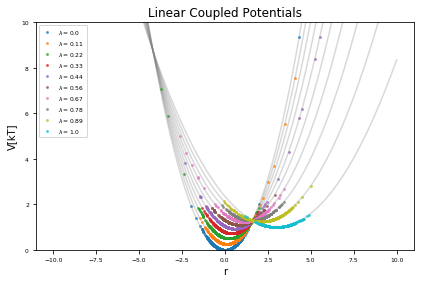

In [15]:
from ensembler import visualisation

#Visualize
positions = np.linspace(-10, 10, 100)
y_range = [0, 10]


fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
axes = list([axes])
enes = []
all_lams = sorted(list(system_trajs.keys()))
for lamI in all_lams:
    trajI = system_trajs[lamI]
    V_perturbed.set_lam(lamI)
    ene =  V_perturbed.ene(positions)
    enes.append(ene)
    
    axes[0].plot(positions,ene, c="grey", zorder=-10,alpha=0.3)
    axes[0].scatter(trajI.position, V_perturbed.ene(trajI.position),s=8,alpha=0.8, linewidths=0, 
                    label="$\lambda=$"+str(round(lamI, 2)),)#c="orange")
    
logExp=list(map(lambda x: np.log(np.exp(x)), enes))

#axes[1].violinplot(logExp, positions=all_lams, showextrema=False, widths=[0.1 for x in range(len(all_lams))])
#axes[1].boxplot(logExp,  positions=np.round(all_lams, 2), widths=[0.1 for x in range(len(all_lams))])

axes[0].legend()
axes[0].set_ylim(y_range)
axes[0].set_ylabel("V[kT]")
axes[0].set_xlabel("r")
axes[0].set_title("Linear Coupled Potentials")

#axes[1].set_xlim([-0.2,1.2])
#axes[1].set_ylim([-1,30])

fig.savefig("linear_coupled.png")

### FEP with multiple lambda windows:

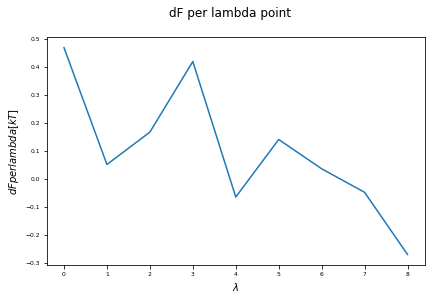


Expected Result:  0.699006798919
trapez Rule Result:  0.913839118623

Difference: 0.214832319704


(0.21483231970409522,)

In [16]:
dA_i_fw = []
zwanz = zwanzigEquation()
all_lams = list(sorted(list(system_trajs.keys())))
for lamI, lamJ in zip(all_lams, all_lams[1:]):
    trajI = system_trajs[lamI]
    trajJ = system_trajs[lamJ]

    Vi_fw = trajI.totPotEnergy
    Vj_fw = trajJ.totPotEnergy

    
    dF_zwanzig_fw = zwanz.calculate(Vi=Vi_fw, Vj=Vj_fw)
    
    dA_i_fw.append(dF_zwanzig_fw)

fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
axes.plot(dA_i_fw)
axes.set_ylabel("$dFper lambda [kT]$")
axes.set_xlabel("$\lambda$")

fig.suptitle("dF per lambda point")

plt.show()

A_fw = np.sum(dA_i_fw)

print()
print("Expected Result: ", dG_expected)
print("trapez Rule Result: ", A_fw)
print()
print("Difference:", A_fw - dG_expected)


A_fw-dG_expected,

#### Thermodynamic Integration

Text(0.5, 0.98, 'dH/d$\\lambda$ for each Lambda point')

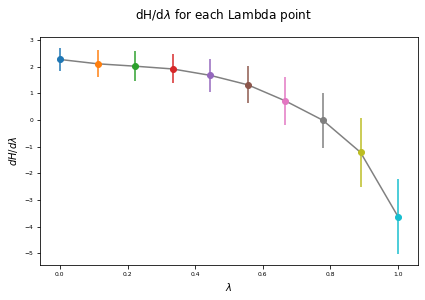

In [17]:
fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)

lam_stats = {}
for lam in system_trajs:
    lam_mean, lam_std = np.mean(system_trajs[lam].dhdlam[equilibration_steps:]), np.std(system_trajs[lam].dhdlam[equilibration_steps:])
    lam_stats.update({lam:{"mean":lam_mean, "std": lam_std}})
    
    axes.scatter(lam, lam_mean)
    axes.errorbar(lam, lam_mean, lam_std)

axes.plot(sorted(lam_stats), [lam_stats[x]["mean"] for x in sorted(lam_stats)], color="grey", zorder=-1)
axes.set_ylabel("$dH/d\lambda$")
axes.set_xlabel("$\lambda$")

fig.suptitle("dH/d$\lambda$ for each Lambda point")


In [18]:
from scipy import integrate

lam = list(sorted(lam_stats.keys()))
means = [lam_stats[x]['mean'] for x in lam] 
stds = [lam_stats[x]['std'] for x in lam] 


In [19]:
dF_trapez = integrate.trapz(x=lam, y=means)
dF_err = integrate.trapz(x=lam, y=stds)

print()
print("Expected Result: ", dG_expected)
print("trapez Rule Result: ", dF_trapez, "+-", dF_err)
print()
print("Difference:", dF_trapez - dG_expected)



Expected Result:  0.699006798919
trapez Rule Result:  0.869871430569 +- 0.786318087149

Difference: 0.17086463165


## Exponentially Coupled - Enveloping Distribution Sampling (EDS) - BAR/RewightedFEP

Text(0.5, 1.0, 'Sampled Potentials')

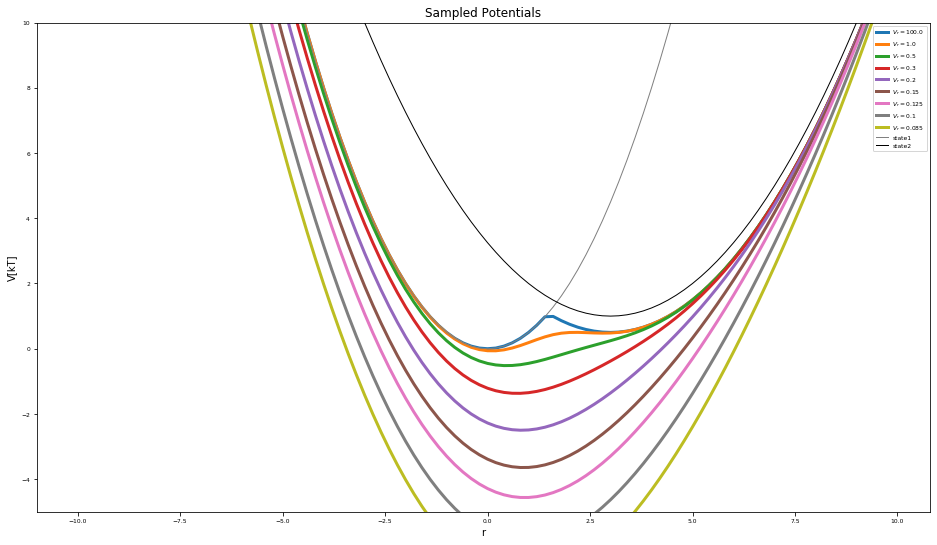

In [280]:
#Build Potential
s=100
Eoff = [0,0.5]
V_eds = pot.envelopedPotential(V_is=[h1,h2] , s=s, Eoff_i=Eoff)
s_values = np.array([100, 1, 0.5, 0.3, 0.2, 0.15, 0.125, 0.1, 0.085])

#Visualize
positions = np.arange(-10,10, 0.2)
fig = plt.figure(figsize=[16,9])

for s in s_values:
    V_eds.s=s
    plt.plot(positions,V_eds.ene(positions), lw=3, label="$V_r="+str(round(s,3))+"$")

plt.plot(positions,h1.ene(positions), label="state1", lw=1, color="grey")
plt.plot(positions,h2.ene(positions), label="state2", lw=1, color="black")


plt.legend()  
plt.ylim([-5,10])
#plt.xlim([-2,8])

plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")

In [282]:
steps = simulation_steps_total_per_approach*2
equilibration_steps = 100

integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
eds_system = edsSystem(potential=V_eds, integrator=integrator, eds_Eoff=Eoff)
eds_simulation_trajs = []

for ind,s in enumerate(s_values):
    print(ind, "\t", s)
    eds_system.set_s(s)
    eds_system.simulate(steps, withdrawTraj=True, initSystem=True)
    state1_traj = eds_system.getTrajectory()
    eds_simulation_trajs.append(state1_traj)
    

0 	 100.0



1 	 1.0



2 	 0.5



3 	 0.3



4 	 0.2



5 	 0.15



6 	 0.125



7 	 0.1



8 	 0.085


In [ ]:
#Visualisation
seperateeach=3
rel_max = 5

nTrajs = len(eds_simulation_trajs)
nrows = (nTrajs//seperateeach)+1 if(nTrajs%seperateeach >0) else(nTrajs//seperateeach)
ncols = seperateeach if(nTrajs>seperateeach) else nTrajs

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=[16,9])
axes= np.concatenate(axes)
for ind, traj in enumerate(eds_simulation_trajs):
    V_eds.s_i = traj.s[1]
    ene =  V_eds.ene(positions)
    axes[ind].plot(positions, h1.ene(positions), c="black" )
    axes[ind].plot(positions, h2.ene(positions), c="black" )
    axes[ind].plot(positions, ene, c="grey", )
    axes[ind].scatter(list(traj.position[equilibration_steps:]), traj.totPotEnergy[equilibration_steps:], c="C"+str(ind%10))
    axes[ind].set_ylim([np.min(ene)-1,np.min(ene)+rel_max])
    axes[ind].set_title("$s = "+str(round(traj.s[1],3))+"$")


In [ ]:
from ensembler import visualisation
    
traj = eds_simulation_trajs[0]
positions = np.linspace(-10,10, 100)
h1_ene = h1.ene(positions)
h2_ene = h2.ene(positions)
V_eds.s = traj.s[0]
eds_ene = V_eds.ene(positions)

traj_pos = list(traj.position)
traj_ene = list(traj.totPotEnergy)

fig, ax = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
ax = list([ax])
ax[0].plot(positions, h1_ene, c="grey", zorder=-10,alpha=0.3)
ax[0].plot(positions, h2_ene, c="black", zorder=-10,alpha=0.3)
ax[0].plot(positions, eds_ene, c="C0", zorder=-10,alpha=0.3)

ax[0].scatter(traj_pos, traj_ene, c="C0",alpha=0.8, label="state 1",s=8)

ax[0].set_ylim([0,8])
ax[0].set_xlabel("r")
ax[0].set_ylabel("$V/[kT]$")

ax[0].legend()
ax[0].set_title("EnDS")

fig.savefig("EDS.png")

### FEP-EDS_Evaluation

In [ ]:
rew_zwanz = threeStateZwanzigReweighting(kT=True)

dFresults = []
s_vals = []
for ind,traj in enumerate(eds_simulation_trajs):
    #print("SIMULATION ", ind)
    s_vals.append(traj.s[1])
    traj_positions = traj.position[equilibration_steps:]
    Vr = traj.totEnergy[equilibration_steps:]
    V1 = h1.ene(traj_positions)
    V2 = h2.ene(traj_positions)

    dFRew_zwanz = rew_zwanz.calculate(Vi=V1, Vj=V2, Vr=Vr)
    
    dFresults.append(dFRew_zwanz)
    
print()
print("\tExpected Result: ", dG_expected)
print("s\t\tdF\t\tdiff")
print("\n".join(map(str, ["\t\t".join(map(str, np.round(x,5))) for x in  zip(s_vals, dFresults, dFresults - dG_expected)])))
print("\n\n\n")


### BAR-EDS_Evaluation

In [251]:

dF_BAR_results = []
s_vals = []

for ind,traj in enumerate(eds_simulation_trajs):
    s_vals.append(traj.s[1])

    traj_positions = traj.position[equilibration_steps:]
    Vr = traj.totEnergy[equilibration_steps:]
    V1 = h1.ene(traj_positions)
    V2 = h2.ene(traj_positions)
    
    print(V1)
    w_fw = np.array(V1 - Vr, dtype=np.float)
    w_rv = np.array(V2 - Vr, dtype=np.float)

    (DeltaF, dDeltaF)=pymbar.BAR(w_F=w_fw, w_R=w_rv, DeltaF=0, method='bisection', verbose=False)
    dF_BAR_results.append(dFRew_zwanz)

    #print("SIMULATION ", ind)
    #print("\ts = ", str(round(traj.s[1],3)))
    #print(DeltaF, DeltaF-dG_expected)
    
print(dF_BAR_results)
        
print()
print("\tExpected Result: ", dG_expected)
print("s\t\tdF\t\tdiff")
print("\n".join(map(str, ["\t\t".join(map(str, np.round(x,5))) for x in  zip(s_vals, dF_BAR_results, dF_BAR_results - dG_expected)])))
print("\n\n\n")

[0.098415860736673355 0.021064480277032102 0.020993601037041152 ...,
 0.27205188873566777 0.1142213862661861 0.057150566799815609]
[0.39315563321736779 0.00065439499294293066 0.015665137350907899 ...,
 0.00092244057966677092 0.057720672009556447 0.0037934506411435266]
[0.14998503916572747 0.1420727446721842 0.3713945204847357 ...,
 0.60723721522484475 0.21818905286561169 0.0062342069360311848]
[0.38326673669617134 0.04227695268494161 0.59790158897011136 ...,
 0.35511254289517707 0.11847776898214878 0.0028560412074893735]
[0.48172226541598728 0.28418616260500612 3.0948096252900466e-06 ...,
 0.37334859444945873 1.3516611765474014 0.55624244813794133]
[1.143407501148461 0.87172392042422708 1.1545059167217715 ...,
 0.16724936433258716 0.62691959070523784 0.51052679263261591]
[1.6791071699374394, 1.6791071699374394, 1.6791071699374394, 1.6791071699374394, 1.6791071699374394, 1.6791071699374394]

	Expected Result:  0.699006798919
s		dF		diff
100.0		1.67911		0.9801
1.0		1.67911		0.9801
0.5		1

# Hybrid Methods - $\lambda-EDS $

0 	 1.0
1 	 0.5
2 	 0.3
3 	 0.2
4 	 0.15
5 	 0.125
6 	 0.1
7 	 0.085


Text(0.5, 1.0, 'Sampled Potentials')

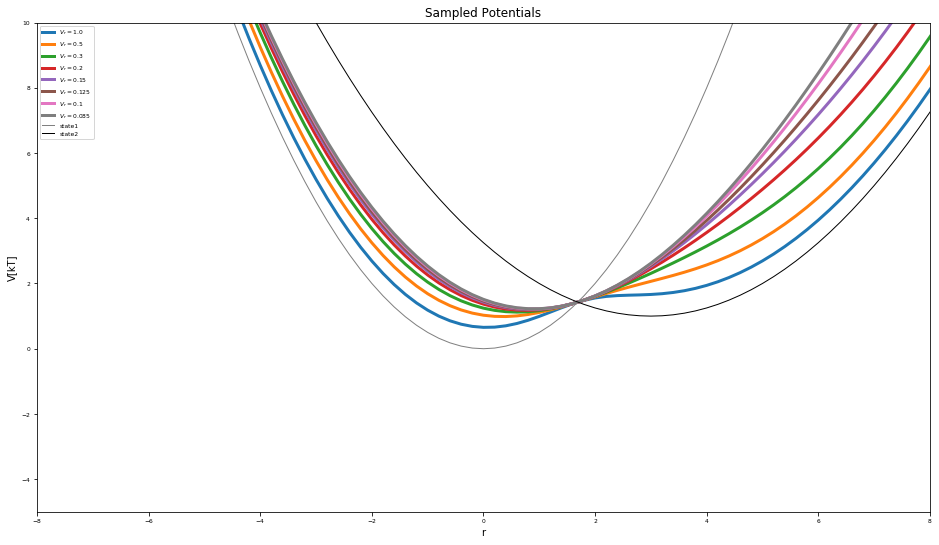

In [245]:
#Build Potential
s=1
V_hleds = pot.hybridCoupledPotentials(Va=h1, Vb=h2, s=1, lam=0.5)

#Build Potential
Eoff = [0,0.5]
V_hleds = pot.lambdaEDSPotential(V_is=[h1,h2] , s=s)
s_values = np.array([1, 0.5, 0.3, 0.2, 0.15, 0.125, 0.1, 0.085])

#Visualize
positions = np.arange(-10,10, 0.2)
fig = plt.figure(figsize=[16,9])

for ind,s in enumerate(s_values):
    print(ind, "\t", s)
    V_hleds.s=s
    plt.plot(positions,V_hleds.ene(positions), lw=3, label="$V_r="+str(round(s,3))+"$")

plt.plot(positions,h1.ene(positions), label="state1", lw=1, color="grey")
plt.plot(positions,h2.ene(positions), label="state2", lw=1, color="black")


plt.legend()  
plt.ylim([-5,10])
plt.xlim([-8,8])

plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")


In [246]:
#simulate
steps = simulation_steps_total_per_approach
equilibration_steps = 100

integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
hleds_system = edsSystem(potential=V_hleds, integrator=integrator, eds_Eoff=Eoff)
hleds_simulation_trajs = []

for s in s_values:
    hleds_system.set_s(s)
    print(hleds_system.potential)
    hleds_system.simulate(steps, withdrawTraj=True, initSystem=True)
    state_traj = hleds_system.getTrajectory()
    hleds_simulation_trajs.append(state_traj)


lambdaEDSPotential
	States: 2
	Dimensions: nDims

	Functional:
 		V:	-T*kb*log(Sum(exp(-Matrix([
[s_0*(-Eoff_0 + state_0)],
[s_1*(-Eoff_1 + state_1)]])[i, 0]/(T*kb))*Matrix([
[lam_0],
[lam_1]])[i, 0], (i, 0, N - 1)))/s_i
		dVdpos:	0

	Simplified Function
		V:	-log(Sum(exp(-Matrix([
[                0.5*r**2],
[0.25*r**2 - 1.5*r + 3.25]])[i, 0])*Matrix([
[0.5],
[0.5]])[i, 0], (i, 0, 1)))/s_i
		dVdpos:	-Sum(-exp(-Matrix([
[                0.5*r**2],
[0.25*r**2 - 1.5*r + 3.25]])[i, 0])*Matrix([
[0.5],
[0.5]])[i, 0]*Matrix([
[      1.0*r],
[0.5*r - 1.5]])[i, 0], (i, 0, 1))/(s_i*Sum(exp(-Matrix([
[                0.5*r**2],
[0.25*r**2 - 1.5*r + 3.25]])[i, 0])*Matrix([
[0.5],
[0.5]])[i, 0], (i, 0, 1)))

	Constants: 
		amp_0: 			1
		amp_1: 			1
		mult_0: 			3
		mult_1: 			3
		yOff_0: 			0
		yOff_1: 			0
		nDim: 			2
		phase_0: 			0
		phase_1: 			0
		nDim: 			2
		nStates: 			1
		T: 			1
		kb: 			1
		N: 			2
		nDims: 			1
		state_0: 			0.5*r**2
		state_1: 			0.25*r**2 - 1.5*r + 3.25
		Eoff_0: 	


lambdaEDSPotential
	States: 2
	Dimensions: nDims

	Functional:
 		V:	-T*kb*log(Sum(exp(-Matrix([
[s_0*(-Eoff_0 + state_0)],
[s_1*(-Eoff_1 + state_1)]])[i, 0]/(T*kb))*Matrix([
[lam_0],
[lam_1]])[i, 0], (i, 0, N - 1)))/s_i
		dVdpos:	0

	Simplified Function
		V:	-log(Sum(exp(-Matrix([
[                0.5*r**2],
[0.25*r**2 - 1.5*r + 3.25]])[i, 0])*Matrix([
[0.5],
[0.5]])[i, 0], (i, 0, 1)))/s_i
		dVdpos:	-Sum(-exp(-Matrix([
[                0.5*r**2],
[0.25*r**2 - 1.5*r + 3.25]])[i, 0])*Matrix([
[0.5],
[0.5]])[i, 0]*Matrix([
[      1.0*r],
[0.5*r - 1.5]])[i, 0], (i, 0, 1))/(s_i*Sum(exp(-Matrix([
[                0.5*r**2],
[0.25*r**2 - 1.5*r + 3.25]])[i, 0])*Matrix([
[0.5],
[0.5]])[i, 0], (i, 0, 1)))

	Constants: 
		amp_0: 			1
		amp_1: 			1
		mult_0: 			3
		mult_1: 			3
		yOff_0: 			0
		yOff_1: 			0
		nDim: 			2
		phase_0: 			0
		phase_1: 			0
		nDim: 			2
		nStates: 			1
		T: 			1
		kb: 			1
		N: 			2
		nDims: 			1
		state_0: 			0.5*r**2
		state_1: 			0.25*r**2 - 1.5*r + 3.25
		Eoff_0: 


lambdaEDSPotential
	States: 2
	Dimensions: nDims

	Functional:
 		V:	-T*kb*log(Sum(exp(-Matrix([
[s_0*(-Eoff_0 + state_0)],
[s_1*(-Eoff_1 + state_1)]])[i, 0]/(T*kb))*Matrix([
[lam_0],
[lam_1]])[i, 0], (i, 0, N - 1)))/s_i
		dVdpos:	0

	Simplified Function
		V:	-log(Sum(exp(-Matrix([
[                0.5*r**2],
[0.25*r**2 - 1.5*r + 3.25]])[i, 0])*Matrix([
[0.5],
[0.5]])[i, 0], (i, 0, 1)))/s_i
		dVdpos:	-Sum(-exp(-Matrix([
[                0.5*r**2],
[0.25*r**2 - 1.5*r + 3.25]])[i, 0])*Matrix([
[0.5],
[0.5]])[i, 0]*Matrix([
[      1.0*r],
[0.5*r - 1.5]])[i, 0], (i, 0, 1))/(s_i*Sum(exp(-Matrix([
[                0.5*r**2],
[0.25*r**2 - 1.5*r + 3.25]])[i, 0])*Matrix([
[0.5],
[0.5]])[i, 0], (i, 0, 1)))

	Constants: 
		amp_0: 			1
		amp_1: 			1
		mult_0: 			3
		mult_1: 			3
		yOff_0: 			0
		yOff_1: 			0
		nDim: 			2
		phase_0: 			0
		phase_1: 			0
		nDim: 			2
		nStates: 			1
		T: 			1
		kb: 			1
		N: 			2
		nDims: 			1
		state_0: 			0.5*r**2
		state_1: 			0.25*r**2 - 1.5*r + 3.25
		Eoff_0: 


lambdaEDSPotential
	States: 2
	Dimensions: nDims

	Functional:
 		V:	-T*kb*log(Sum(exp(-Matrix([
[s_0*(-Eoff_0 + state_0)],
[s_1*(-Eoff_1 + state_1)]])[i, 0]/(T*kb))*Matrix([
[lam_0],
[lam_1]])[i, 0], (i, 0, N - 1)))/s_i
		dVdpos:	0

	Simplified Function
		V:	-log(Sum(exp(-Matrix([
[                0.5*r**2],
[0.25*r**2 - 1.5*r + 3.25]])[i, 0])*Matrix([
[0.5],
[0.5]])[i, 0], (i, 0, 1)))/s_i
		dVdpos:	-Sum(-exp(-Matrix([
[                0.5*r**2],
[0.25*r**2 - 1.5*r + 3.25]])[i, 0])*Matrix([
[0.5],
[0.5]])[i, 0]*Matrix([
[      1.0*r],
[0.5*r - 1.5]])[i, 0], (i, 0, 1))/(s_i*Sum(exp(-Matrix([
[                0.5*r**2],
[0.25*r**2 - 1.5*r + 3.25]])[i, 0])*Matrix([
[0.5],
[0.5]])[i, 0], (i, 0, 1)))

	Constants: 
		amp_0: 			1
		amp_1: 			1
		mult_0: 			3
		mult_1: 			3
		yOff_0: 			0
		yOff_1: 			0
		nDim: 			2
		phase_0: 			0
		phase_1: 			0
		nDim: 			2
		nStates: 			1
		T: 			1
		kb: 			1
		N: 			2
		nDims: 			1
		state_0: 			0.5*r**2
		state_1: 			0.25*r**2 - 1.5*r + 3.25
		Eoff_0: 


lambdaEDSPotential
	States: 2
	Dimensions: nDims

	Functional:
 		V:	-T*kb*log(Sum(exp(-Matrix([
[s_0*(-Eoff_0 + state_0)],
[s_1*(-Eoff_1 + state_1)]])[i, 0]/(T*kb))*Matrix([
[lam_0],
[lam_1]])[i, 0], (i, 0, N - 1)))/s_i
		dVdpos:	0

	Simplified Function
		V:	-log(Sum(exp(-Matrix([
[                0.5*r**2],
[0.25*r**2 - 1.5*r + 3.25]])[i, 0])*Matrix([
[0.5],
[0.5]])[i, 0], (i, 0, 1)))/s_i
		dVdpos:	-Sum(-exp(-Matrix([
[                0.5*r**2],
[0.25*r**2 - 1.5*r + 3.25]])[i, 0])*Matrix([
[0.5],
[0.5]])[i, 0]*Matrix([
[      1.0*r],
[0.5*r - 1.5]])[i, 0], (i, 0, 1))/(s_i*Sum(exp(-Matrix([
[                0.5*r**2],
[0.25*r**2 - 1.5*r + 3.25]])[i, 0])*Matrix([
[0.5],
[0.5]])[i, 0], (i, 0, 1)))

	Constants: 
		amp_0: 			1
		amp_1: 			1
		mult_0: 			3
		mult_1: 			3
		yOff_0: 			0
		yOff_1: 			0
		nDim: 			2
		phase_0: 			0
		phase_1: 			0
		nDim: 			2
		nStates: 			1
		T: 			1
		kb: 			1
		N: 			2
		nDims: 			1
		state_0: 			0.5*r**2
		state_1: 			0.25*r**2 - 1.5*r + 3.25
		Eoff_0: 


lambdaEDSPotential
	States: 2
	Dimensions: nDims

	Functional:
 		V:	-T*kb*log(Sum(exp(-Matrix([
[s_0*(-Eoff_0 + state_0)],
[s_1*(-Eoff_1 + state_1)]])[i, 0]/(T*kb))*Matrix([
[lam_0],
[lam_1]])[i, 0], (i, 0, N - 1)))/s_i
		dVdpos:	0

	Simplified Function
		V:	-log(Sum(exp(-Matrix([
[                0.5*r**2],
[0.25*r**2 - 1.5*r + 3.25]])[i, 0])*Matrix([
[0.5],
[0.5]])[i, 0], (i, 0, 1)))/s_i
		dVdpos:	-Sum(-exp(-Matrix([
[                0.5*r**2],
[0.25*r**2 - 1.5*r + 3.25]])[i, 0])*Matrix([
[0.5],
[0.5]])[i, 0]*Matrix([
[      1.0*r],
[0.5*r - 1.5]])[i, 0], (i, 0, 1))/(s_i*Sum(exp(-Matrix([
[                0.5*r**2],
[0.25*r**2 - 1.5*r + 3.25]])[i, 0])*Matrix([
[0.5],
[0.5]])[i, 0], (i, 0, 1)))

	Constants: 
		amp_0: 			1
		amp_1: 			1
		mult_0: 			3
		mult_1: 			3
		yOff_0: 			0
		yOff_1: 			0
		nDim: 			2
		phase_0: 			0
		phase_1: 			0
		nDim: 			2
		nStates: 			1
		T: 			1
		kb: 			1
		N: 			2
		nDims: 			1
		state_0: 			0.5*r**2
		state_1: 			0.25*r**2 - 1.5*r + 3.25
		Eoff_0: 


lambdaEDSPotential
	States: 2
	Dimensions: nDims

	Functional:
 		V:	-T*kb*log(Sum(exp(-Matrix([
[s_0*(-Eoff_0 + state_0)],
[s_1*(-Eoff_1 + state_1)]])[i, 0]/(T*kb))*Matrix([
[lam_0],
[lam_1]])[i, 0], (i, 0, N - 1)))/s_i
		dVdpos:	0

	Simplified Function
		V:	-log(Sum(exp(-Matrix([
[                0.5*r**2],
[0.25*r**2 - 1.5*r + 3.25]])[i, 0])*Matrix([
[0.5],
[0.5]])[i, 0], (i, 0, 1)))/s_i
		dVdpos:	-Sum(-exp(-Matrix([
[                0.5*r**2],
[0.25*r**2 - 1.5*r + 3.25]])[i, 0])*Matrix([
[0.5],
[0.5]])[i, 0]*Matrix([
[      1.0*r],
[0.5*r - 1.5]])[i, 0], (i, 0, 1))/(s_i*Sum(exp(-Matrix([
[                0.5*r**2],
[0.25*r**2 - 1.5*r + 3.25]])[i, 0])*Matrix([
[0.5],
[0.5]])[i, 0], (i, 0, 1)))

	Constants: 
		amp_0: 			1
		amp_1: 			1
		mult_0: 			3
		mult_1: 			3
		yOff_0: 			0
		yOff_1: 			0
		nDim: 			2
		phase_0: 			0
		phase_1: 			0
		nDim: 			2
		nStates: 			1
		T: 			1
		kb: 			1
		N: 			2
		nDims: 			1
		state_0: 			0.5*r**2
		state_1: 			0.25*r**2 - 1.5*r + 3.25
		Eoff_0: 


lambdaEDSPotential
	States: 2
	Dimensions: nDims

	Functional:
 		V:	-T*kb*log(Sum(exp(-Matrix([
[s_0*(-Eoff_0 + state_0)],
[s_1*(-Eoff_1 + state_1)]])[i, 0]/(T*kb))*Matrix([
[lam_0],
[lam_1]])[i, 0], (i, 0, N - 1)))/s_i
		dVdpos:	0

	Simplified Function
		V:	-log(Sum(exp(-Matrix([
[                0.5*r**2],
[0.25*r**2 - 1.5*r + 3.25]])[i, 0])*Matrix([
[0.5],
[0.5]])[i, 0], (i, 0, 1)))/s_i
		dVdpos:	-Sum(-exp(-Matrix([
[                0.5*r**2],
[0.25*r**2 - 1.5*r + 3.25]])[i, 0])*Matrix([
[0.5],
[0.5]])[i, 0]*Matrix([
[      1.0*r],
[0.5*r - 1.5]])[i, 0], (i, 0, 1))/(s_i*Sum(exp(-Matrix([
[                0.5*r**2],
[0.25*r**2 - 1.5*r + 3.25]])[i, 0])*Matrix([
[0.5],
[0.5]])[i, 0], (i, 0, 1)))

	Constants: 
		amp_0: 			1
		amp_1: 			1
		mult_0: 			3
		mult_1: 			3
		yOff_0: 			0
		yOff_1: 			0
		nDim: 			2
		phase_0: 			0
		phase_1: 			0
		nDim: 			2
		nStates: 			1
		T: 			1
		kb: 			1
		N: 			2
		nDims: 			1
		state_0: 			0.5*r**2
		state_1: 			0.25*r**2 - 1.5*r + 3.25
		Eoff_0: 

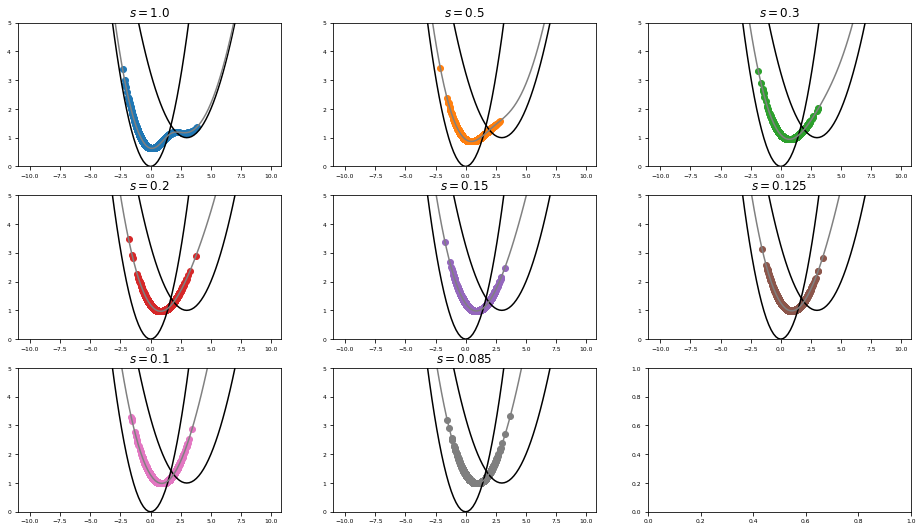

In [247]:
#Visualisation
seperateeach=3
rel_max = 5

nTrajs = len(hleds_simulation_trajs)
nrows = (nTrajs//seperateeach)+1 if(nTrajs%seperateeach >0) else(nTrajs//seperateeach)
ncols = seperateeach if(nTrajs>seperateeach) else nTrajs

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=[16,9])
axes= np.concatenate(axes)
for ind, traj in enumerate(hleds_simulation_trajs):
    V_hleds.s_i = traj.s[1]
    ene =  V_hleds.ene(positions)
    axes[ind].plot(positions, h1.ene(positions), c="black" )
    axes[ind].plot(positions, h2.ene(positions), c="black" )

    axes[ind].plot(positions, ene, c="grey" )
    axes[ind].scatter(list(traj.position[equilibration_steps:]), traj.totPotEnergy[equilibration_steps:], c="C"+str(ind))
    axes[ind].set_ylim([0, rel_max])
    axes[ind].set_title("$s = "+str(round(traj.s[1],3))+"$")


In [248]:
rew_zwanz = threeStateZwanzigReweighting(kT=True)

dFresults = []
s_vals = []
for ind,traj in enumerate(hleds_simulation_trajs):
    #print("SIMULATION ", ind)
    s_vals.append(traj.s[1])
    traj_positions = traj.position[equilibration_steps:]
    Vr = traj.totEnergy[equilibration_steps:]
    V1 = h1.ene(traj_positions)
    V2 = h2.ene(traj_positions)

    dFRew_hleds_zwanz = rew_zwanz.calculate(Vi=V1, Vj=V2, Vr=Vr)
    
    dFresults.append(dFRew_hleds_zwanz)
    
print()
print("\tExpected Result: ", dG_expected)
print("s\t\tdF\t\tdiff")
print("\n".join(map(str, ["\t\t".join(map(str, np.round(x,5))) for x in  zip(s_vals, dFresults, dFresults - dG_expected)])))
print("\n\n\n")



	Expected Result:  0.699006798919
s		dF		diff
1.0		2.87406		2.17505
0.5		2.52769		1.82869
0.3		2.01232		1.31331
0.2		1.74899		1.04999
0.15		1.68101		0.982
0.125		1.66292		0.96392
0.1		1.56879		0.86978
0.085		1.58015		0.88114






#### Enhanced Sampling with system Coupling

#### Conveyor Belt TI

In [29]:
import ensembler.ensemble.replicas_dynamic_parameters as cvb
from ensembler.system import perturbed_system

#CHEKC HERE H1 and H2 die
equilibration_steps = 100
numsys = 4
V_perturbed = pot.linearCoupledPotentials(Va=h1, Vb=h2)
integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)

lam_system = perturbed_system.perturbedSystem(potential=V_perturbed , integrator=integrator)
conveyorBelt=cvb.ConveyorBelt(0.0, numsys, system=lam_system, build=False)


In [30]:
conveyorBelt.simulate(steps//numsys)
cvb_trajs = conveyorBelt.get_trajectories()


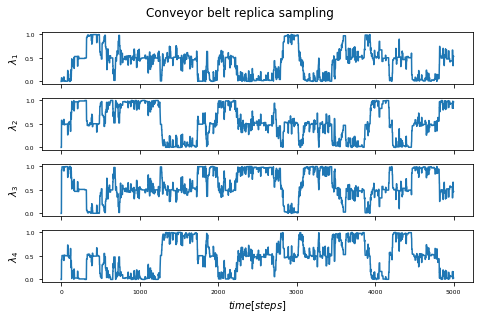

In [31]:
fig, axes = plt.subplots(nrows=4, figsize=style.figsize_doubleColumn, sharex=True)
keys=list(sorted(list(cvb_trajs.keys())))
for key in keys:
    axes[key].plot(cvb_trajs[key].lam)
    axes[key].set_ylabel("$\lambda_"+str(key+1)+"$")
    if(key == keys[-1]):    axes[key].set_xlabel("$time [steps]$")
fig.suptitle("Conveyor belt replica sampling", y=1.05)
fig.tight_layout()

<BarContainer object of 50 artists>

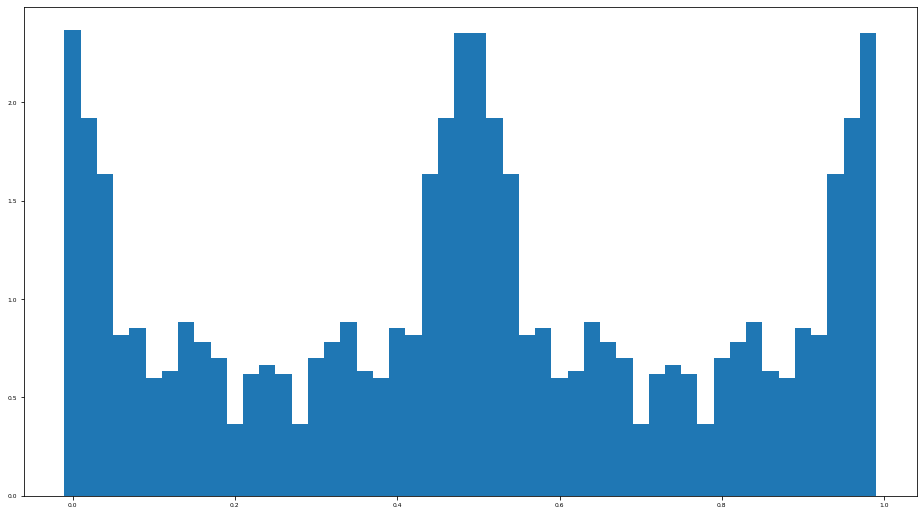

In [202]:
nbins=50
frequencies, lam_bins = np.histogram(list(sorted(np.unique(lambda_stat.lam))), bins=nbins, density=True)
plt.figure(figsize=[16,9])
plt.bar(x=lam_bins[:-1], height=frequencies, width=1/nbins)

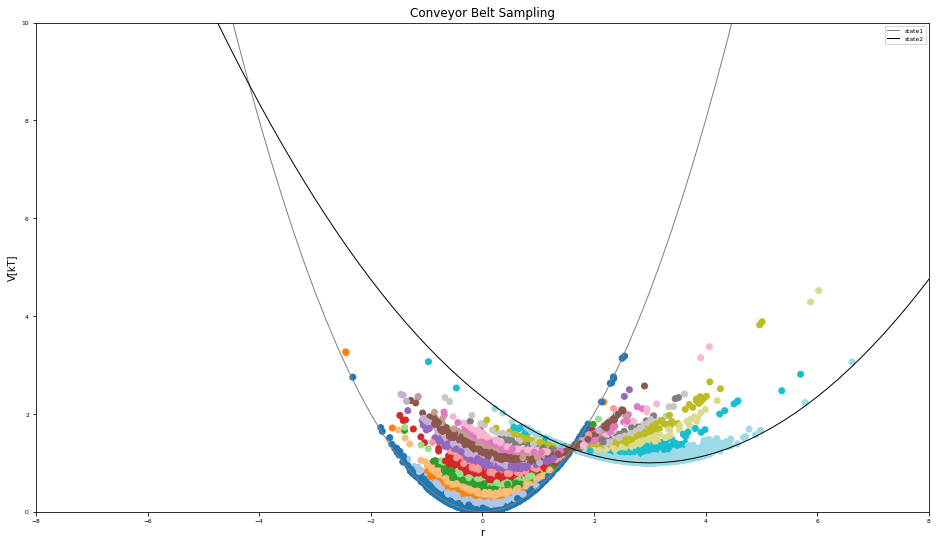

In [203]:
import pandas as pd
mega_traj = pd.concat(list(cvb_trajs.values()), ignore_index=True)

def find_nearest_bin(array,value):
    cbins =[]
    for val in value:
        idx = np.argmin(np.abs(array-val))
        cbins.append(idx)
    return cbins

discrete_traj = np.array(find_nearest_bin(value=mega_traj.lam[equilibration_steps:], array=lam_bins))

fig, axes = plt.subplots(ncols=1, figsize=[16,9])
axes = [axes]
axes[0].scatter(list(mega_traj.position[equilibration_steps:]), mega_traj.totPotEnergy[equilibration_steps:], c=discrete_traj, cmap="tab20")

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)
positions = np.arange(-10,10, 0.2)
axes[0].plot(positions, h1.ene(positions), label="state1", lw=1, color="grey")
axes[0].plot(positions, h2.ene(positions), label="state2", lw=1, color="black")

axes[0].legend()  
axes[0].set_ylim([0,10])
axes[0].set_xlim([-8,8])

axes[0].set_ylabel("V[kT]")
axes[0].set_xlabel("r")
axes[0].set_title("Conveyor Belt Sampling")
fig.savefig("CVB_sampling.png")

In [204]:
from scipy import integrate

lambda_stat = mega_traj[["lam","dhdlam"]]

means_cvb = np.nan_to_num([np.mean(lambda_stat.loc[np.where(discrete_traj==x+1)].dhdlam) for x in range(nbins+1)])
std_cvb = np.nan_to_num([np.std(lambda_stat.loc[np.where(discrete_traj==x+1)].dhdlam) for x in range(nbins+1)] )
means_cvb

array([ 1.84845435,  1.48219172,  1.87777119,  1.53287841,  1.24507965,
        1.28439051,  1.83493884,  1.33064822,  1.73150781,  1.83902663,
        1.52075133,  1.51745423,  1.27269123,  1.4281933 ,  1.3369308 ,
        1.3338874 ,  1.03254927,  1.16081147,  0.76523982,  0.42043272,
        0.89450518,  1.2163846 ,  0.60517432,  0.9262758 ,  1.08544413,
        0.90960253,  1.1349579 ,  0.63797354,  1.31114689,  1.39185234,
        0.90538207,  0.35653468,  1.2078331 ,  0.45393856,  0.80363577,
        0.10288789,  0.0337002 , -0.17481397, -0.53220343, -0.7281962 ,
       -0.94345782, -0.8309465 , -0.12719925,  0.07982869, -0.63860511,
       -0.81154937, -1.04046232, -0.52729519, -1.01803794, -1.28208589,  0.        ])

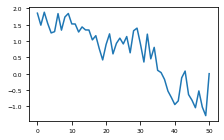

In [205]:
plt.plot(means_cvb)

In [206]:
dF_trapez = integrate.trapz(x=lam_bins, y=means_cvb)
dF_err = integrate.trapz(x=lam_cvb, y=stds_cvb)

print()
print("Expected Result: ", dG_expected)
print("trapez Rule Result: ", dF_trapez, "+-", dF_err)
print()
print("Difference:", dF_trapez - dG_expected)



Expected Result:  0.699006798919
trapez Rule Result:  0.645471766597 +- 0.458916266396

Difference: -0.0535350323215


# RE-EDS

In [ ]:
#potential
Eoff = [0,1]
V_eds = pot.envelopedPotential(V_is=[h1,h2])

##Integrator
integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)

##System
eds_system = edsSystem(integrator=integrator, potential=V_eds)
eds_system.Eoff = Eoff
print(eds_system.potential.Eoff)

##Ensemble
from ensembler.ensemble import replica_exchange
##Ensemble Settings:
s_values = [100]+list(np.logspace(start=0, stop=-1, num=5))
trials=200
steps_between_trials=simulation_steps_total_per_approach//(len(s_values)*trials)

print("DO trials: ", trials, "steps: ", steps_between_trials)
ensemble = replica_exchange.ReplicaExchangeEnvelopingDistributionSampling(system=eds_system, exchange_criterium=None, s_range=s_values, steps_between_trials=steps_between_trials)
[replica.s for repID, replica in ensemble.replicas.items()]

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

#Visualize
positions = np.arange(-10,10, 0.2)
fig = plt.figure(figsize=[16,9])

for ind,replica in ensemble.replicas.items():
    print(ind, "\t", replica)
    print(replica.potential.s)
    print(replica.potential.Eoff)

    V_hleds.s=s
    plt.plot(positions,replica.potential.ene(positions), lw=3, label="$replica "+str(ind+1)+"$")

plt.plot(positions,h1.ene(positions), label="state1", lw=1, color="grey")
plt.plot(positions,h2.ene(positions), label="state2", lw=1, color="black")


plt.legend()  
plt.ylim([-5,10])
plt.xlim([-8,8])

plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")


In [210]:
ensemble.simulate(trials, reset_ensemble=True)
reeds_trajs = ensemble.get_trajectories()


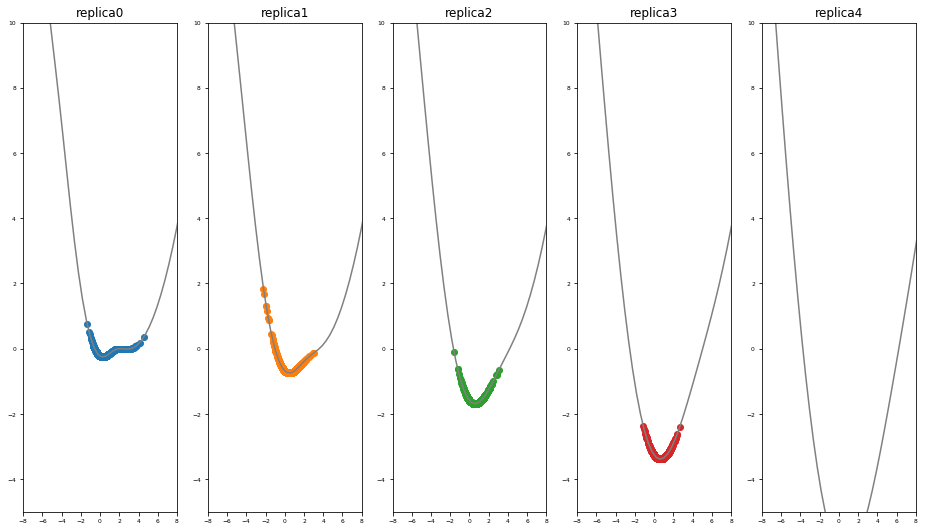

In [215]:

positions = np.linspace(-10,10)
fig, axes = plt.subplots(ncols=len(reeds_trajs), figsize=[16,9])
eqil=100
for traj, ax in zip(reeds_trajs, axes):
    ax.plot(positions, ensemble.replicas[traj].potential.ene(positions), c="grey")
    min_e = np.min(reeds_trajs[traj].totEnergy[eqil:])
    ax.scatter(reeds_trajs[traj].position[eqil:], reeds_trajs[traj].totEnergy[eqil:], c="C"+str(traj))
    ax.set_ylim([min_e-1,min_e+5])
    ax.set_xlim([-4,8])
    ax.set_ylim([-5,10])
    ax.set_xlim([-8,8])
    ax.set_title("replica"+str(traj))


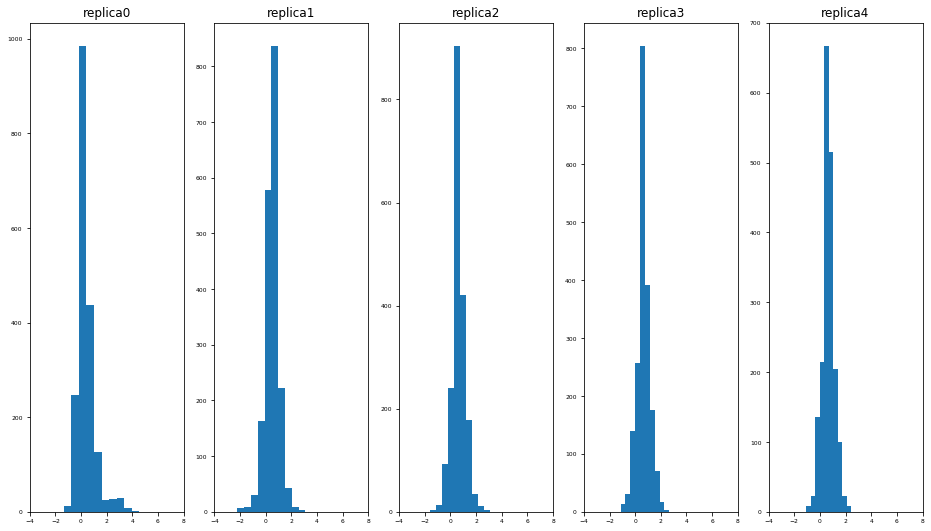

In [216]:
trajs = ensemble.get_trajectories()

positions = np.linspace(-10,10)
fig, axes = plt.subplots(ncols=len(trajs), figsize=[16,9])
eqil=100
for traj, ax in zip(reeds_trajs, axes):
    ax.hist(reeds_trajs[traj].position[eqil:])
    ax.set_xlim([-4,8])
    ax.set_title("replica"+str(traj))


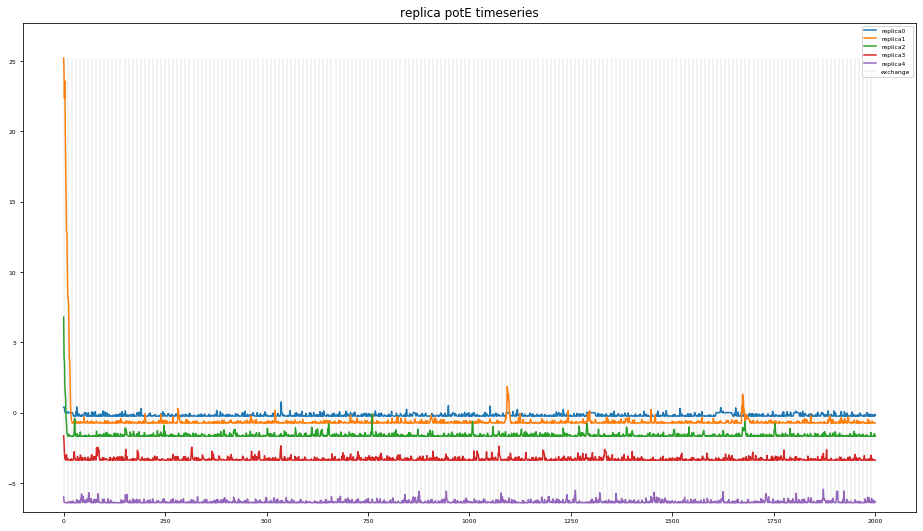

In [217]:

fig, ax = plt.subplots(ncols=1, figsize=[16,9])
enes = [reeds_trajs[x].totEnergy for x in sorted(trajs)] 
min_e = np.min(enes)
max_e = np.max(enes)

for ind, ene in enumerate(enes):
    ax.plot(ene, label="replica"+str(ind))
ax.vlines([steps_between_trials*x for x in range(trials)], ymin=min_e, ymax=max_e, label="exchange", lw=0.1)
ax.set_title("replica potE timeseries")
ax.set_ylim(1.1*min_e, 1.1*max_e)
ax.legend()

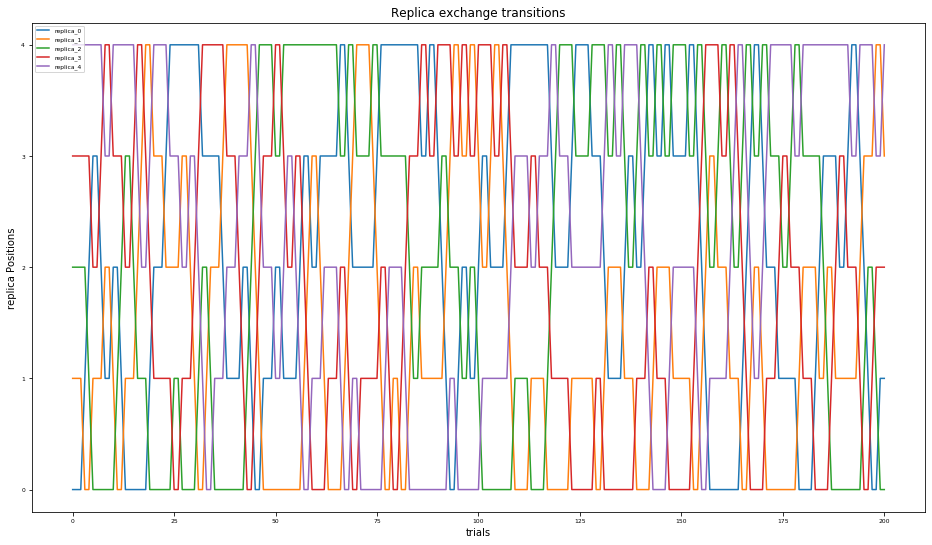

In [218]:
stats= ensemble.exchange_information
replicas = np.unique(ensemble.exchange_information.replicaID)
trials = np.unique(ensemble.exchange_information.nExchange)

import itertools as it

fig, ax = plt.subplots(ncols=1, figsize=[16,9])

replica_positions = {}
for replica in replicas:
    replica_positions.update({replica: stats.loc[stats.replicaID==replica].replicaPositionI})

    x = trials
    y = replica_positions[replica]

    ax.plot(x,y , label="replica_"+str(replica))

#plt.yticks(replicas+1, reversed(replicas+1))
ax.set_yticks(ticks=replicas)
ax.set_yticklabels(labels=replicas)

ax.set_ylabel("replica Positions")
ax.set_xlabel("trials")
ax.set_title("Replica exchange transitions")
if(len(replicas)<10): plt.legend()

In [221]:
rew_zwanz = threeStateZwanzigReweighting(kT=True)

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

dFresults = []
s_vals = []
for ind,key in enumerate(reeds_trajs):
    #print("SIMULATION ", ind)
    s_vals.append(reeds_trajs[key].s[1])
    traj_positions = reeds_trajs[key].position[equilibration_steps:]
    Vr = reeds_trajs[key].totEnergy[equilibration_steps:]
    V1 = h1.ene(traj_positions)
    V2 = h2.ene(traj_positions)

    dFRew_hleds_zwanz = rew_zwanz.calculate(Vi=V1, Vj=V2, Vr=Vr)
    
    dFresults.append(dFRew_hleds_zwanz)
    
print()
print("\tExpected Result: ", dG_expected)
print("s\t\tdF\t\tdiff")
print("\n".join(map(str, ["\t\t".join(map(str, np.round(x,5))) for x in  zip(s_vals, dFresults, dFresults - dG_expected)])))
print("\n\n\n")



	Expected Result:  0.699006798919
s		dF		diff
1.0		-0.63407		-1.33308
0.56234		1.67923		0.98022
0.31623		1.52836		0.82935
0.17783		1.51933		0.82032
0.1		1.52327		0.82427




